# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sampleSubmission.csv')

- datetime: hourly date + timestamp
- season: 1=봄, 2=여름, 3=가을, 4=겨울
- holiday: 1=주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날
- workingday: 1=주말 및 휴일이 아닌 주중, 0=주말 및 휴일
- weather:
1=맑음, 약간 구름 낀 흐림
2=안개, 안개 + 흐림
3=가벼운 눈, 가벼운 비 + 천둥
4=심한 눈/비, 천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않은 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

In [3]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [4]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 n

(None, None)

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 데이터 탐색(EDA)

<AxesSubplot:ylabel='Frequency'>

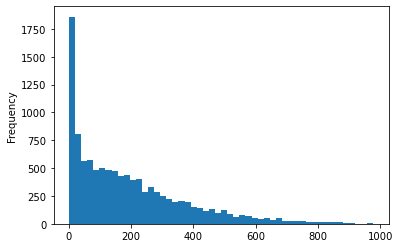

In [6]:
train['count'].plot(kind='hist', bins=50)

- 예측 타겟(count)이 정규 분포가 아닌 0 ~ 200 사이에 왜곡돼 있는 것으로 확인 됨 
- 따라서 로그 변환을 통해 이를 정규 분포 형태로 변환할 것

<AxesSubplot:ylabel='Frequency'>

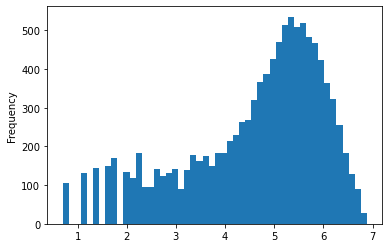

In [7]:
y_log_transform = np.log1p(train['count'])
y_log_transform.plot(kind='hist', bins=50)

- 로그 변환후 확인해보니 정규 분포 형태를 띄는것을 확인할 수 있음

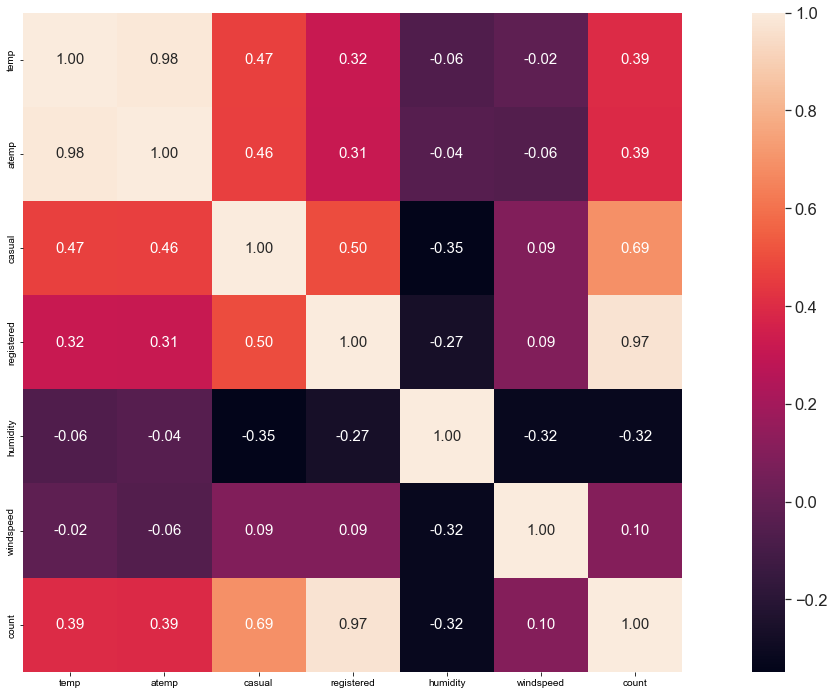

In [8]:
cols = ["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]
corr = train[cols].corr(method='pearson')
corr.values

# 우선 fig를 통해서 차트의 크기를 조정
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# 위에서 얻은 ax값을 ax의 인자값으로 넣는다. ax=ax
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols,
            ax=ax)

plt.tight_layout()
plt.show()

In [9]:
train.corr()['count']

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
count         1.000000
Name: count, dtype: float64

- 전반적으로 피처들의 상관관계가 낮은 경향이 있음.
- casual, registered는 상관관계는 높지만 test 데이터에 존재하지 않아 예측에 사용하기는 어렵다.
- atemp, temp는 0.98로 매우 높은 상관관계를 보이지만, 사실살 같은 의미를 가진 데이터로 보이고, 다중공선성의 문제가 있는것으로 보인다.

# 데이터 전처리

In [10]:
# datetime -> year, month, day, hout 로 세분화

train['datetime'] = train.datetime.apply(pd.to_datetime)

train["year"] = train["datetime"].dt.year # 연
train["month"] = train["datetime"].dt.month # 월
train["day"] = train["datetime"].dt.day # 일
train["hour"] = train["datetime"].dt.hour # 시간

In [11]:
# 데이터 수기보완 : holiday, workingday 피처에 데이터 오류가 발견되어 이를 수정

dt = pd.DatetimeIndex(train['datetime'])
train.set_index(dt, inplace=True)
dtt = pd.DatetimeIndex(test['datetime'])
test.set_index(dtt, inplace=True)
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0
train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [12]:
# 로그변환

train['count'] = np.log1p(train['count'])

In [13]:
# 원핫 인코딩(pd.get_dumies)

train = pd.get_dummies(train, columns = ['holiday', 'workingday', 'season', 'weather'])

In [14]:
# 데이터 분할(타겟 데이터 설정)

train_df = train.drop(['datetime','casual','registered','temp'], axis=1)
X_train = train_df.drop('count', axis=1)
y_train = train_df['count']

# 모델링

In [15]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()

lr_reg.fit(X_train, y_train)
lr_reg.score(X_train, y_train)

0.49590808891954796

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, y_train)
rf_reg.score(X_train, y_train)

0.9930492200465466

# 모델 튜닝

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats  import randint

param_distribs = { 
    'n_estimators' : randint(low=1, high=200),
    'max_features' : randint(low=1, high=8),
    'min_samples_leaf' : randint(low=1, high=18),
    'min_samples_split' : randint(low=1, high=20)
}

forest_reg = RandomForestRegressor(random_state=42)

rnd_search = RandomizedSearchCV(forest_reg, param_distribs, n_iter=10, cv=5, # 10 x 5
                                scoring="neg_root_mean_squared_error", random_state=42, n_jobs=-1)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002020971BFD0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020209D192E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020209CAE820>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002020971B160>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [32]:
rnd_search.best_params_

{'max_features': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 51}

In [33]:
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

0.7520970039653507 {'max_features': 7, 'min_samples_leaf': 15, 'min_samples_split': 11, 'n_estimators': 72}
0.7737206503768602 {'max_features': 5, 'min_samples_leaf': 7, 'min_samples_split': 19, 'n_estimators': 75}
0.8169746083467642 {'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 152}
0.8109869237188853 {'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 158}
nan {'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 58}
0.7595835977528286 {'max_features': 6, 'min_samples_leaf': 12, 'min_samples_split': 17, 'n_estimators': 59}
0.7518087772455844 {'max_features': 7, 'min_samples_leaf': 10, 'min_samples_split': 16, 'n_estimators': 15}
0.7693022380588801 {'max_features': 6, 'min_samples_leaf': 15, 'min_samples_split': 19, 'n_estimators': 108}
0.7098499462559459 {'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 51}
0.7365978566296691 {'max_features': 7, 'min_samp

In [18]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 75}

In [19]:
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

0.7007226383231303 {'max_features': 7, 'n_estimators': 52}
0.7410524711712247 {'max_features': 5, 'n_estimators': 15}
0.7916753139385713 {'max_features': 3, 'n_estimators': 72}
0.7344905479530162 {'max_features': 5, 'n_estimators': 21}
0.6987858383614431 {'max_features': 7, 'n_estimators': 83}
0.6983104543722881 {'max_features': 7, 'n_estimators': 75}
0.7888998110465185 {'max_features': 3, 'n_estimators': 88}
0.7314350320758337 {'max_features': 5, 'n_estimators': 24}
0.8064559922698378 {'max_features': 3, 'n_estimators': 22}
0.855845278329009 {'max_features': 5, 'n_estimators': 2}


In [20]:
final_model = rnd_search.best_estimator_

# 예측


In [21]:
# 예측 test데이터 세트 생성

test['datetime'] = test.datetime.apply(pd.to_datetime)

test["year"] = test["datetime"].dt.year # 연
test["month"] = test["datetime"].dt.month # 월
test["day"] = test["datetime"].dt.day # 일
test["hour"] = test["datetime"].dt.hour # 시간

test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 12, 24)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 12, 31)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 26)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 31)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1
test.loc[get_day(pd.datetime(2011, 12, 24)), "holiday"] = 1
test.loc[get_day(pd.datetime(2011, 12, 31)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 12, 31)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1

test = pd.get_dummies(test, columns = ['holiday', 'workingday', 'season', 'weather'])


X_test = test.drop(['datetime','temp'], axis=1)

In [25]:
# 튜닝된 파라미터로 예측

pred = final_model.predict(X_test)
pred = np.expm1(pred)
pred

array([10.15723363,  6.38170061,  4.60872151, ..., 97.02351731,
       87.62744236, 62.24533602])

In [24]:
# 예측

pred = rf_reg.predict(X_test)

pred = np.expm1(pred)
pred

array([12.93301273,  5.54570993,  4.14741034, ..., 96.66985562,
       99.61476989, 68.4302781 ])

# 특성 중요도

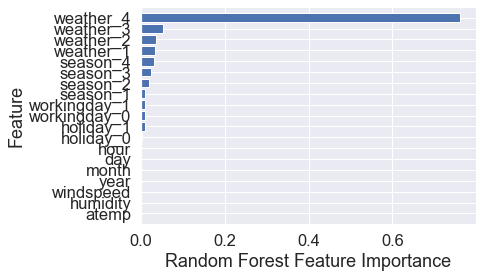

In [45]:
def plot_feature_importance(model):
    n_features = X_test.shape[1]
    plt.barh(np.arange(n_features), sorted(model.feature_importances_), align="center")
    plt.yticks(np.arange(n_features), X_test.columns)
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf_reg)

# 파일 제출

In [27]:
submission['count'] = pred

In [28]:
# 예외처리

# submission['count'] = np.where(submission['count'] <0 , submission['count'].mean() , submission['count'])

In [29]:
submission.to_csv('data/baseline5.csv', index=False)

In [34]:
submission[submission['count'] < 0]

,datetime,count
